# Ch6 - Possible problem in AI training and Solution

In [105]:
import numpy as np
import matplotlib.pyplot as plt

(List the possible problems & solution encountered during training AI network)

## Neural network training

### Introduction

In the following of the notebook, we are using the *Iris flower dataset* for training.
(Explanation on the data, the components of data, no of data)

(The structure of the AI model, activation function & output layer function in between, optimization methods and loss function, batch size, test case,  )

### Data preparation

Below are the steps of data preparation,

1. Load the data from *sklearn* module
2. Normalization
3. Convert the label for training (Understand why do we need to do this)
4. Split the train and test case

In [106]:
from sklearn import datasets

iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target

no_of_data = len(correct)

In [107]:
# Print the first 10 data & take a look of the data
print(input_data[:10,])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]]


In [108]:
# Normalization
mean_col = np.mean(input_data,axis=0)
std_col = np.std(input_data,axis=0)
normalized_data = (input_data - mean_col)/(std_col)

Turn the `correct` to one-hot labelling (Add the graph of one-hot labelling scheme & why do we need to turn it to one-hot)

In [109]:
# Turn the `correct` to one-hot labelling
correct_data = np.zeros((no_of_data,3),dtype=int)

# TODO: Figure out a way to make use the vectorization
for i in range(no_of_data):
    correct_data[i][correct[i]] = 1


In [110]:
# Split the data to test & learn case
from sklearn.model_selection import train_test_split

input_train, input_test, correct_train, correct_test = train_test_split(
    normalized_data,
    correct_data,
    test_size=no_of_data//2
)

n_train = no_of_data//2

### Network structure

1. Define the hyperparameters & initial vaules for the network
2. Define the layer structure as object
3. Forward and back propagation definition


In [111]:
# Nework neuron
n_in = 4 # since we get 4 features for each x
n_mid = 25
n_out = 3

eta = 0.01      # learning rate for SGD
epoch = 1000    # No of training times
batch_size = 8

interval = 100  # Showing the training accuracy every (interval) times

(ReLu definition, Softmax expression)

In [112]:
# Define the layer structure & methods

# Define the common properities in BaseLayer
class BaseLayer:
  def __init__(self,n_upper,n, wb_width = 0.1): # n_upper - no of neurons in last layer, n - no of neurons
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)

  def update(self,eta):
    self.w -= eta * self.grad_w
    self.b -= eta * self.grad_b

# Middle layer
class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u<=0, 0, self.u) # ReLu activation function ]

  def backward(self,grad_y):
    delta = grad_y * np.where(self.u<=0, 0, 1) # grad_y * derivative of ReLu

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)

# Output layer
class OutputLayer(BaseLayer):
  def forward(self,x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.exp(self.u)/(np.sum(np.exp(self.u),axis=1,keepdims=True))

  def backward(self,t):
    delta = self.y - t

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)


In [113]:
# Neural network structure

middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid,n_out)

In [114]:
# Group the forward, backward propagation, update_weight of different layer in the function

def forward_propagation(x):
  middle_layer_1.forward(x)
  middle_layer_2.forward(middle_layer_1.y)
  output_layer.forward(middle_layer_2.y)

def backward_propagation(t):
  output_layer.backward(t)
  middle_layer_2.backward(output_layer.grad_x)
  middle_layer_1.backward(middle_layer_2.grad_x)

def update_wb(eta):
  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  output_layer.update(eta)

def get_error(t, batch_size):
  # Basically calcaluating the cost function value and normalize with the batch size
  # add 1e-7 to avoid ln(0)
  return -np.sum(t * np.log(output_layer.y + 1e-7))/batch_size

### Training procedures

In [115]:
train_error = []

test_error = []

no_of_batch = n_train // batch_size

for i in range(epoch):

  # Record the error on training & test case in every training
  forward_propagation(input_train)
  train_error.append(get_error(correct_train, batch_size))

  forward_propagation(input_test)
  test_error.append(get_error(correct_test, batch_size))

  # Shuffle the data & prepare the index
  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(no_of_batch):

    mini_batch_index = index_random[j*batch_size:(j+1)*batch_size]
    x = input_train[mini_batch_index, :]
    t = correct_train[mini_batch_index, :]

    forward_propagation(x)
    backward_propagation(t)
    update_wb(eta)

Text(0, 0.5, 'Error')

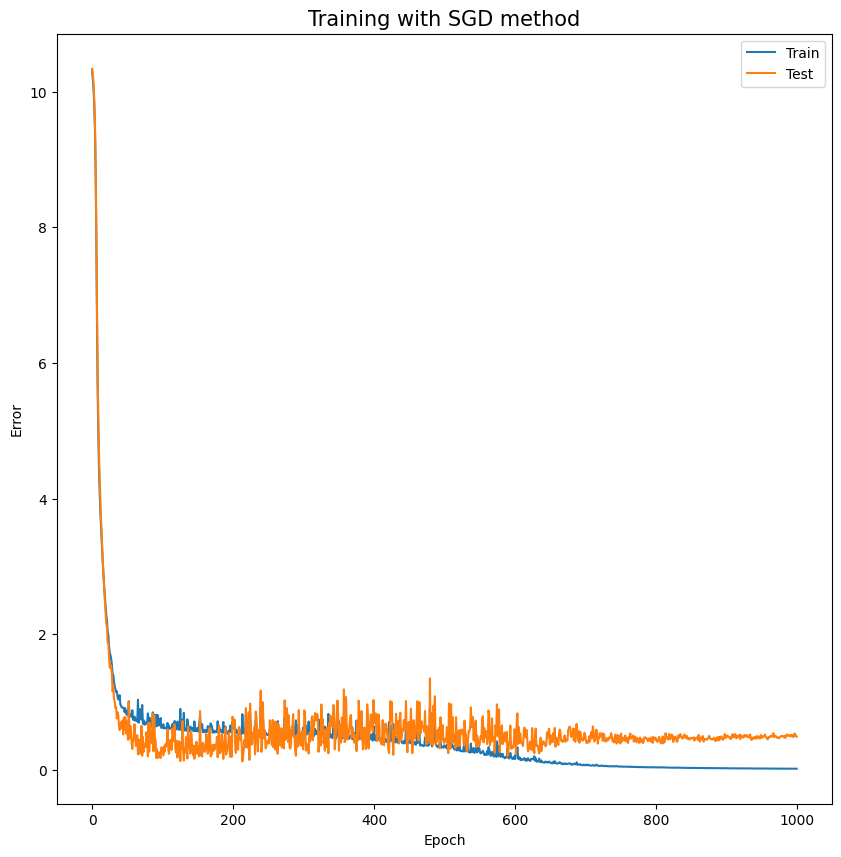

In [116]:
# Visualize the training process
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title("Training with SGD method",fontsize=15)
plt.plot(np.arange(epoch), train_error, label="Train")
plt.plot(np.arange(epoch), test_error, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")


It is clear from the plot the overfitting problem occurs. The different in error between the train & test case becomes larger after `epoch=100`.

## Methods dealing with overfitting

In the following of the section, we are going to implement 2 methods to deal with overfitting.

1. Changing Stochastic Gradient Descent (SGD) to Adaptive Gradient Descent (AdaGrad)
2. Add the dropout layer in between the different layer

### Adaptive Gradient Descent

In [117]:
# Redefine the BaseLayer object to support AdaGrad

# Define the common properities in BaseLayer
class BaseLayer:
  def __init__(self,n_upper,n, wb_width = 0.1): # n_upper - no of neurons in last layer, n - no of neurons
    self.w = wb_width * np.random.randn(n_upper, n)
    self.b = wb_width * np.random.randn(n)

    self.h_w = np.zeros((n_upper, n)) + 1e-8 # add 1e-8 to avoid division by 0
    self.h_b = np.zeros((n)) + 1e-8

  def update(self,eta):
    self.w -= eta * self.grad_w
    self.b -= eta * self.grad_b

  def update_AdaGrad(self,eta):
    self.h_w += np.square(self.grad_w)
    self.w -= eta / np.sqrt(self.h_w) * self.grad_w

    self.h_b += np.square(self.grad_b)
    self.b -= eta / np.sqrt(self.h_b) * self.grad_b

# Middle layer
class MiddleLayer(BaseLayer):
  def forward(self, x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.where(self.u<=0, 0, self.u) # ReLu activation function ]

  def backward(self,grad_y):
    delta = grad_y * np.where(self.u<=0, 0, 1) # grad_y * derivative of ReLu

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)

# Output layer
class OutputLayer(BaseLayer):
  def forward(self,x):
    self.x = x
    self.u = np.dot(x, self.w) + self.b
    self.y = np.exp(self.u)/(np.sum(np.exp(self.u),axis=1,keepdims=True))

  def backward(self,t):
    delta = self.y - t

    self.grad_w = np.dot(self.x.T, delta)
    self.grad_b = np.sum(delta, axis=0)

    self.grad_x = np.dot(delta, self.w.T)


In [118]:
def update_wb_AdaGrad(eta):
    middle_layer_1.update_AdaGrad(eta)
    middle_layer_2.update_AdaGrad(eta)
    output_layer.update_AdaGrad(eta)

In [119]:
# Redine the network structure

middle_layer_1 = MiddleLayer(n_in, n_mid)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
output_layer = OutputLayer(n_mid,n_out)

In [120]:
# Training - With AdaGrad

# TODO: Ammend the following code in next session

train_error = []

test_error = []

no_of_batch = n_train // batch_size

for i in range(epoch):

  # Record the error on training & test case in every training
  forward_propagation(input_train)
  train_error.append(get_error(correct_train, batch_size))

  forward_propagation(input_test)
  test_error.append(get_error(correct_test, batch_size))

  # Shuffle the data & prepare the index
  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(no_of_batch):

    mini_batch_index = index_random[j*batch_size:(j+1)*batch_size]
    x = input_train[mini_batch_index, :]
    t = correct_train[mini_batch_index, :]

    forward_propagation(x)
    backward_propagation(t)
    update_wb_AdaGrad(eta)

Text(0, 0.5, 'Error')

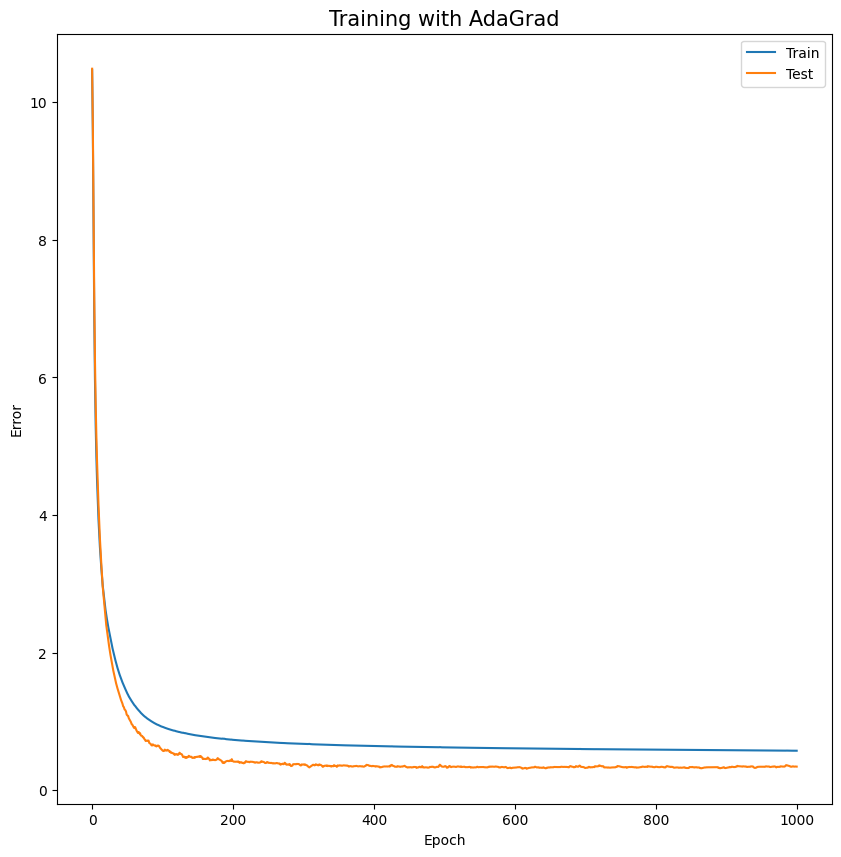

In [121]:
# Visualize the training process
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title("Training with AdaGrad",fontsize=15)
plt.plot(np.arange(epoch), train_error, label="Train")
plt.plot(np.arange(epoch), test_error, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")

### Dropout Layer

(How do you implement the dropout layer)

In [122]:
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio

    def forward(self, x, is_train_flag):

        if is_train_flag: # only use the dropout layer during training. Switch this when testing

            rand_matrix = np.random.rand(*x.shape) # Generate matrix with same shape as x and no in [0,1]
            self.dropout = np.where(rand_matrix>self.dropout_ratio,1,0)
            self.y = x * self.dropout

        else:
            self.y = (1 - self.dropout_ratio)*x # To maintain the same proportionn of the data for testing

    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout # Only pass the value of neuron that has not been dropped out in the forward propagation

In [123]:
# Redine the network structure

middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)

middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)

output_layer = OutputLayer(n_mid,n_out)

In [124]:
# Redefine the way for doing forward and backward propagation

def forward_propagation(x,is_train_flag):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y,is_train_flag)

    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y,is_train_flag)

    output_layer.forward(dropout_2.y)

def backward_propagation(t):
    output_layer.backward(t)

    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)

    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)

In [125]:
# Training - With AdaGrad + Dropout

train_error = []

test_error = []

no_of_batch = n_train // batch_size

for i in range(epoch*2):

  # Record the error on training & test case in every training
  forward_propagation(input_train,is_train_flag=True)
  train_error.append(get_error(correct_train, batch_size))

  forward_propagation(input_test,is_train_flag=False)
  test_error.append(get_error(correct_test, batch_size))

  # Shuffle the data & prepare the index
  index_random = np.arange(n_train)
  np.random.shuffle(index_random)

  for j in range(no_of_batch):

    mini_batch_index = index_random[j*batch_size:(j+1)*batch_size]
    x = input_train[mini_batch_index, :]
    t = correct_train[mini_batch_index, :]

    forward_propagation(x,is_train_flag=True)
    backward_propagation(t)
    update_wb_AdaGrad(eta)

Text(0, 0.5, 'Error')

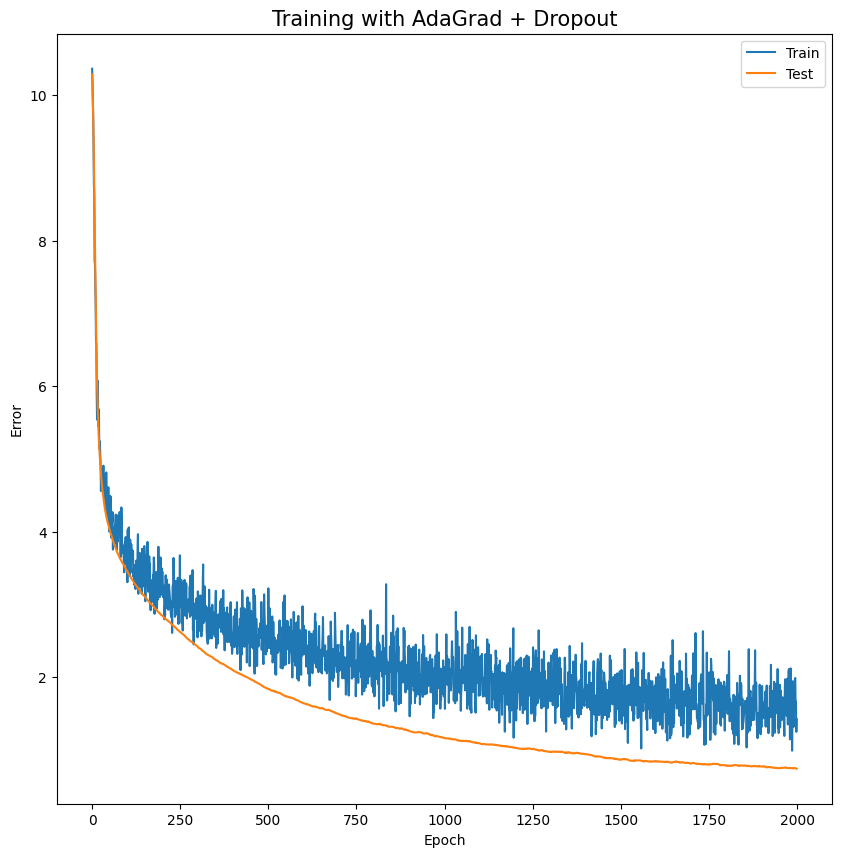

In [126]:
# Visualize the training process
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title("Training with AdaGrad + Dropout",fontsize=15)
plt.plot(np.arange(epoch*2), train_error, label="Train")
plt.plot(np.arange(epoch*2), test_error, label="Test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")

## Implementation of the same model with Pytorch Library